This notebook rolls together much of what happens in .../daq.../teledyne/adq.../spurAnlysis.ipynb
The data set was taken overnight on 3_23_23 using the full set up with all bells and whistles (no temperature saved, but was being collected on DR1)

DR1 and 2 were in the room and on. GPS was connected and NEO7 had power from an arduino. Both arduinos were on. Patch pannel was terminated on the outside only. Agilent DMM and lakeshore were on and probes were attached. 

In [42]:
import sys 
import numpy as np
import settings as s
import matplotlib.pyplot as plt 
import importlib
importlib.reload(s)
from cupyx.profiler import benchmark
import h5py
import os
import re
import time
import datetime
from datetime import datetime

sys.path.insert(0, '../../../drlib')
import drlib as dr
%matplotlib widget

def mad_np(arr):
    median = np.median(arr)
    return np.median(np.abs(arr-median))

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2Freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

dataDir         = '/drBiggerBoy/moreTesting_3_23_23/'

totalAcqs       = int(open(s.SAVE_DIRECTORY + 'database.txt', 'r'
                    ).readlines()[-1].split(',')[0].strip()) + 1 

print(totalAcqs)
    

594


diff mean:              65.53445392074198
diff median:            65.533829
diff STD:               0.004388645789291895
diff percent error:     0.006696700020724315
expected single time:   6.553599999999999
total time:             38861.931175
expected total time:    26214.399999999998


Text(0, 0.5, 'Time Delta (Seconds)')

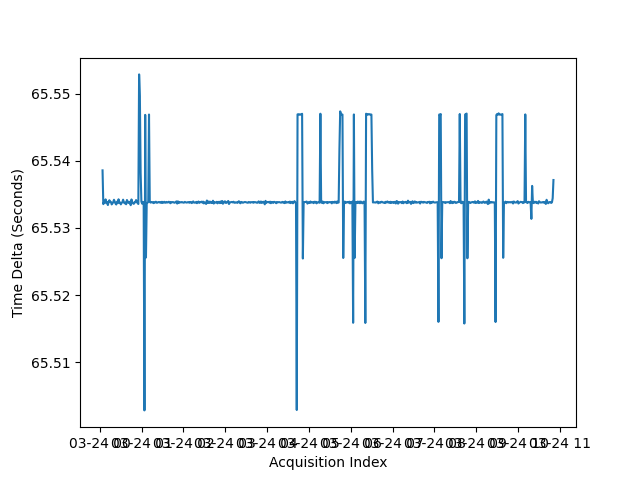

In [43]:
#time delta analysis
datetimes_str = np.loadtxt(f'{dataDir}database.txt',
                        skiprows=1,
                        usecols=1,
                        delimiter=',',
                        dtype=str)
datetimes =[]
for date in datetimes_str:
    data = date[10]
    datetimes.append(datetime.strptime(date, ' %Y-%m-%d %H:%M:%S.%f'))


diff = []
for i in range(len(datetimes)-1):
    diff.append((datetimes[i+1] - datetimes[i]).total_seconds())

print(f"diff mean:              {np.mean(diff)}")
print(f"diff median:            {np.median(diff)}")
print(f"diff STD:               {np.std(diff)}")
print(f"diff percent error:     {np.std(diff)/np.mean(diff) * 100}")
print(f"expected single time:   {2**24/s.SAMPLE_RATE * 250}")
print(f"total time:             {(datetimes[-1] - datetimes[0]).total_seconds()}")
print(f"expected total time:    {2**24/s.SAMPLE_RATE * s.NOF_BUFFERS_TO_RECEIVE * s.NOF_ACQUISITIONS_TO_TAKE}")

plt.close('all')
plt.figure()
plt.plot(datetimes[1:], diff)
plt.xlabel('Acquisition Index')
plt.ylabel('Time Delta (Seconds)')

In [5]:
#pack pre proc dataset

try:
    f.close()
    print("closed")
except:
    print("didn't close")
    pass

rawDataDir      = dataDir + 'data/'
fileList        = os.listdir(rawDataDir)
fileList.sort(key=lambda f: int(re.sub('\D', '', f)))
newDataDir      = dataDir
fileName        = 'packedh5.hdf5'
if 0: #will overwrite!!!

    f               = h5py.File(newDataDir + fileName, 'w')

    #init empty dataset
    print(f'initilizing dataset 8388609x{totalAcqs}')
    spec_W    = f.create_dataset('spec_W_chB', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    print(spec_W)

    ##############################################################
    #Main loop
    ##############################################################
    numFiles        = 0
    numMeasData     = 0
    numRigolSpec    = 0

    compType = False
    chunks = None #must add chunks arg to create dataset calls

    for fileidx, file in enumerate(fileList):
        if fileidx % 10 == 0:
            print(file)
        dataset         = h5py.File(rawDataDir +  file, 'r')
        numFiles        += 1
        measDataKeys    = list(dataset.keys())
        measDataKeys.sort(key=lambda f: int(re.sub('\D', '', f)))
        #measDataKeys = [int(key) for key in measDataKeys]

        for measData in measDataKeys:
            measDataInt = int(measData)
            '''Dumb check. Is the date in raw h5 measData the same as what
            the database thinks it is? Since we previously check that dates
            are consectutive this also checks that dates 
            in raw h5 are consecutive'''
            '''datasetDf   = pd.read_hdf(rawDataDir + file, key = measData)#raw H5 
            dateTimeStr = datasetDf.columns[0][0]#datetime extracted from raw H5
            dateTime    = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S.%f')'''

            '''Check database at a measData has the same datetime as we are about
            to load into new h5'''
            '''if not (dateTime==database[database['measData'] == measDataInt].index):
                print('Dates got jumbled at measData', measDataInt)'''

            spec_W_np        = np.float32(dataset[measData]['chBSpec_W'])
            #print(measData)
            #termSpec    = np.float32(dr.fft2Watts(datasetDf.iloc[:,0][:]))
            #diffSpec    = np.float32((antSpec-termSpec))

            spec_W[:, measDataInt]    = spec_W_np

f.close()

didn't close


In [25]:
#Average and save spectra

#location of packed h5
fileName        = 'packedh5.hdf5'


f               = h5py.File(dataDir + fileName, 'r')

def avgSpecFromPacked(avgIdxs):
    sum = np.zeros(2**23+1)
    for i in avgIdxs:
        sum += f['spec_W_chB'][:,i]
    avgSpec = sum/(len(avgIdxs))
    return avgSpec

def rollingMadLim(spec,
    nSigma = 5,
    order = 1,
    fc_numBins = 100
):
    specFiltered = dr.filterSpec(spec, fc_numBins=fc_numBins, order=order)
    window = 1000

    rollingMadArr = dr.rolling(specFiltered, window, 1, mad_np, numProc=48)

    filter_fc           = 30 * window
    filteredMadArr  = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
    diffFilterMadPadArr = dr.nanPad(filteredMadArr, window)
    rollMadLim      = diffFilterMadPadArr * nSigma * 1.48
    return rollMadLim, specFiltered, nSigma, order, fc_numBins

#Average and save
if 0:
    antIdxs     = range(0, totalAcqs-1, 2)[0:-1]
    termIdxs    = range(1, totalAcqs-1, 2)
    avgAntSpec  = avgSpecFromPacked(antIdxs)
    avgtermSpec  = avgSpecFromPacked(termIdxs)

    np.save('/drBiggerBoy/moreTesting_3_23_23/analysisSpecs/avgAntSpec_W_296Avgs_3_23_23', avgAntSpec)
    np.save('/drBiggerBoy/moreTesting_3_23_23/analysisSpecs/avgTermSpec_W_296Avgs_3_23_23', avgtermSpec)
    print('Done saving raw spectra')

    #filter/rolling mad limit and save
    antRollingMadLim, antFilt, Sigma, order, fc_numBins     = rollingMadLim(avgAntSpec)
    termRollingMadLim, termFilt, nSigma, order, fc_numBins   = rollingMadLim(avgtermSpec)

    np.save(f'/drBiggerBoy/moreTesting_3_23_23/analysisSpecs/antRollingMadLim_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23', antRollingMadLim)
    np.save(f'/drBiggerBoy/moreTesting_3_23_23/analysisSpecs/termRollingMadLim_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23', termRollingMadLim)
    np.save(f'/drBiggerBoy/moreTesting_3_23_23/analysisSpecs/antFilt_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23', antFilt)
    np.save(f'/drBiggerBoy/moreTesting_3_23_23/analysisSpecs/termFilt_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23', termFilt)

    f.close()

Done saving raw spectra
done mp
done mp


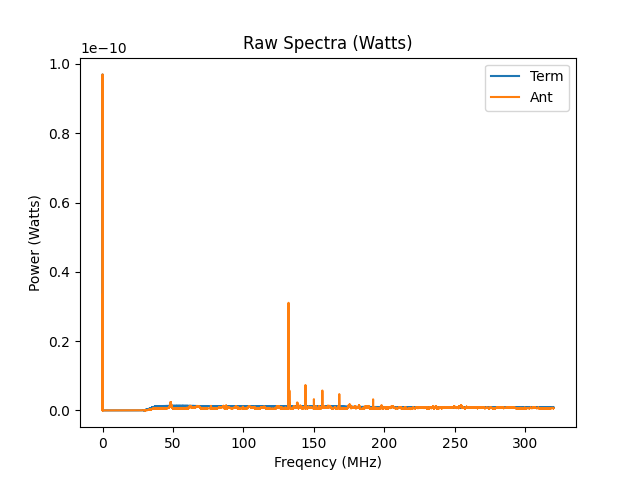

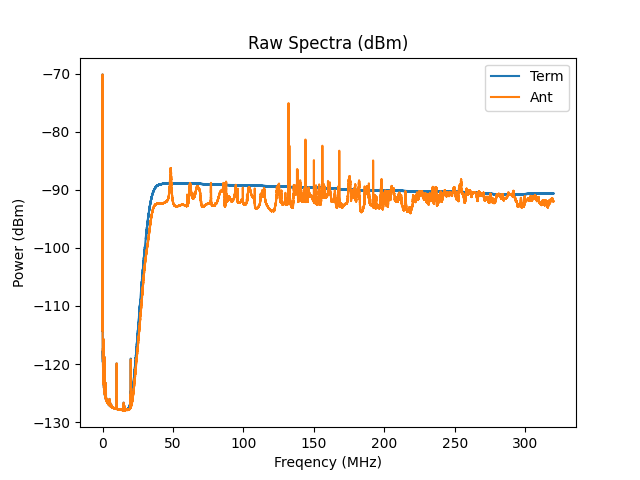

In [48]:
#load files generated in previous cell

avgAntSpec          = np.load(dataDir+'avgAntSpec_W_296Avgs_3_23_23.npy', allow_pickle=True)
avgTermSpec         = np.load(dataDir+'avgTermSpec_W_296Avgs_3_23_23.npy', allow_pickle=True)
filtAntSpec         = np.load(dataDir+f'analysisSpecs/antFilt_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23.npy', 
    allow_pickle=True
)
filtTermSpec        = np.load(dataDir+f'analysisSpecs/termFilt_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23.npy', 
    allow_pickle=True
)
termRollingMadLim   = np.load(dataDir+f'analysisSpecs/termRollingMadLim_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23.npy',
    allow_pickle=True
)
antRollingMadLim   = np.load(dataDir+f'analysisSpecs/antRollingMadLim_W_296Avgs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_23_23.npy',
    allow_pickle=True
)

#plot raw spectra
freqs       = np.linspace(0, 320, 2**23)

plt.close('all')

plt.title('Raw Spectra (Watts)')
plt.plot(freqs, avgTermSpec[1:], label = 'Term')
plt.plot(freqs, avgAntSpec[1:], label = 'Ant')
plt.ylabel('Power (Watts)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')

plt.figure()
plt.title('Raw Spectra (dBm)')
plt.plot(freqs, 10*np.log10(avgTermSpec[1:]*1000), label = 'Term')
plt.plot(freqs, 10*np.log10(avgAntSpec[1:]*1000), label = 'Ant')
plt.ylabel('Power (dBm)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')


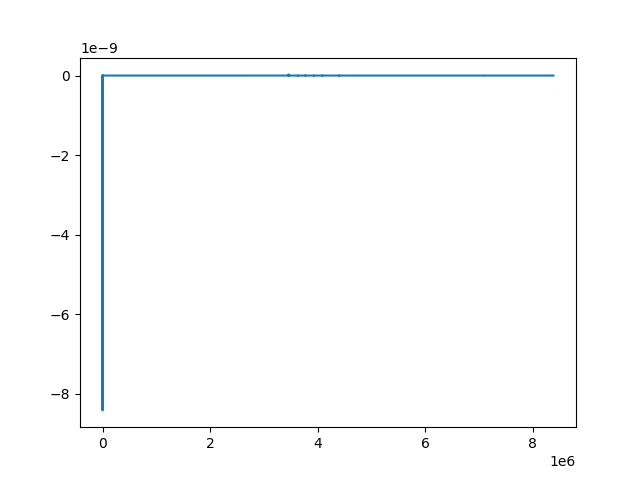

In [46]:
plt.close('all')
plt.figure()
plt.plot(filtAntSpec)

1379 antenna candidates
2 term candidates


Text(0, 0.5, 'Filtered Watts')

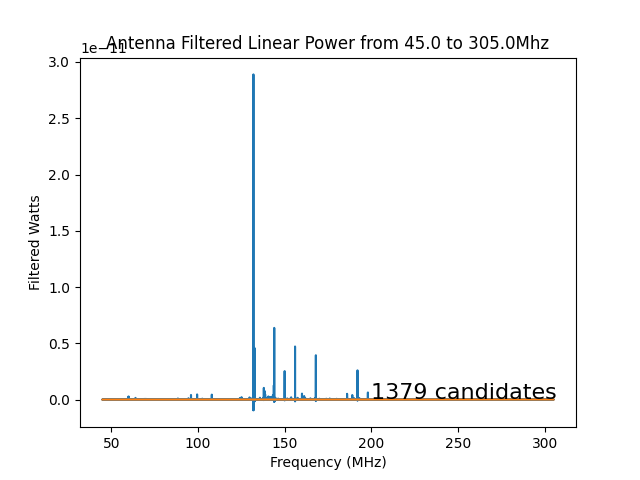

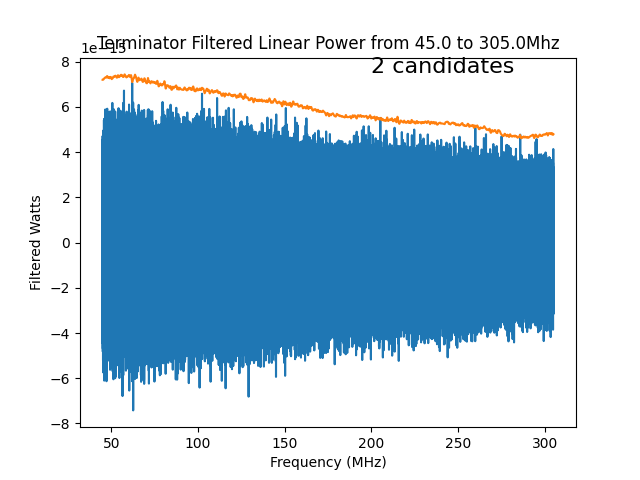

In [49]:
pltFreqStart = 45e6
pltFreqStop = 305e6
freqs=np.linspace(0,s.SAMPLE_RATE/2, 2**23)
pltIdxStart = freq2Idx(pltFreqStart, freqs)
pltIdxStop = freq2Idx(pltFreqStop, freqs)

antCanList_idx = ((filtAntSpec > antRollingMadLim)) 
antCandidateTotal = (antCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{antCandidateTotal} antenna candidates")

termCanList_idx = ((filtTermSpec > termRollingMadLim)) 
termCandidateTotal = (termCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{termCandidateTotal} term candidates")


plt.close('all')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtAntSpec[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(antRollingMadLim)[pltIdxStart:pltIdxStop])
plt.text(200,.75e-14, f'{antCandidateTotal} candidates',size=16)
plt.title(f"Antenna Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtTermSpec[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(termRollingMadLim)[pltIdxStart:pltIdxStop])
plt.text(200,.75e-14, f'{termCandidateTotal} candidates',size=16)
plt.title(f"Terminator Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')